# Kaggle波士顿房价预测

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from IPython import display

## 读入训练数据和测试数据

In [2]:
train_data = pd.read_csv(r'/Users/chenyuntao/ML/Datasets/Boston_House_price/train.csv')
test_data = pd.read_csv(r'/Users/chenyuntao/ML/Datasets/Boston_House_price/test.csv')

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


查看前四个特征和最后两个特征，以及相应的标签（房价）

In [4]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可见，第一个特征是ID，有助于识别每个训练样本，但是不携带任何有助于预测的信息。因此将该数据提供给模型之前，需要讲这一列删除

In [5]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [6]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


## 数据预处理

### 缺失值填充

首先填充缺失值，将所有缺失值替换为相应特征的平均值。然后，为了将所有特征放在一个共同尺度上，我们通过将特征重新缩放到零均值和单位方差来标准化数据。

x <- （x-均值）/标准差

In [7]:
#若无法获得测试数据，可以通过训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index   #获取索引

all_features[numeric_features] = all_features[numeric_features].apply(    
    lambda x: ((x - x.mean()) / (x.std()))
)
#标准化数据后，所有均值消失，因此我们将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

### 处理离散值

包括诸如“MSZoing”之类的特征。我们用one-hot编码来替换他们。对于缺失值，我们也将起视为单独的一类

In [8]:
#"Dummy_na = True"将‘na’（缺失值）视为有效的特征值，并自动为其创建指示符特征
all_features = pd.get_dummies(all_features , dummy_na=True)
all_features.shape

(2919, 331)

转换后的会将特征的总数量从79增加到331.通过values属性，我们可以从pandas格式中提取出NumPy格式，并将其转换为张量，用于训练

In [9]:
n_train = train_data.shape[0]
print(n_train)
train_features = torch.tensor(all_features[:n_train].values , dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values , dtype= torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

1460


## 训练

In [10]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features , 1))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。 因此，我们更关心相对误差,而不是绝对误差。解决这个问题的一种方法是用价格预测的对数来衡量差异。 事实上，这也是比赛中官方用来评价提交质量的误差指标。

In [11]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

训练函数将借助Adam优化器。 Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

K折交叉验证有助于模型选择和超参数调整。 我们首先需要定义一个函数，在K折交叉验证过程中返回第i折的数据。 具体地说，它选择第
i个切片作为验证数据，其余部分作为训练数据。 注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。

In [13]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [14]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1},训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择

 有了足够大的数据集和合理设置的超参数，K折交叉验证往往对多次测试具有相当的稳定性。 然而，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。

折1,训练log rmse0.170739, 验证log rmse0.156460
折2,训练log rmse0.162341, 验证log rmse0.191423
折3,训练log rmse0.164050, 验证log rmse0.168215
折4,训练log rmse0.167810, 验证log rmse0.154403
折5,训练log rmse0.163606, 验证log rmse0.182780
5-折验证: 平均训练log rmse: 0.165709, 平均验证log rmse: 0.170656


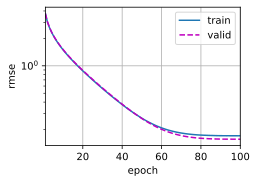

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

有时一组超参数的训练误差可能非常低，但K折交叉验证的误差要高得多， 这表明模型过拟合了。 在整个训练过程中，我们希望监控训练误差和验证误差这两个数字。 较少的过拟合可能表明现有数据可以支撑一个更强大的模型， 较大的过拟合可能意味着我们可以通过正则化技术来获益

In [16]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162423


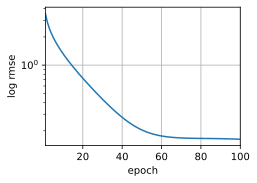

In [17]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)